# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [31]:
# Your code here
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
boston = pd.read_csv("../data/boston_data.csv")
boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,9.32909,0.0,18.10,0.0,0.713,6.185,98.7,2.2616,24.0,666.0,20.2,396.90,18.13,14.1
400,51.13580,0.0,18.10,0.0,0.597,5.757,100.0,1.4130,24.0,666.0,20.2,2.60,10.11,15.0
401,0.01501,90.0,1.21,1.0,0.401,7.923,24.8,5.8850,1.0,198.0,13.6,395.52,3.16,50.0
402,0.02055,85.0,0.74,0.0,0.410,6.383,35.7,9.1876,2.0,313.0,17.3,396.90,5.77,24.7


In [3]:
# 404 rows... a bit short

In [4]:
boston.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

In [5]:
# no missing values

In [6]:
boston.dtypes

crim       float64
zn         float64
indus      float64
chas       float64
nox        float64
rm         float64
age        float64
dis        float64
rad        float64
tax        float64
ptratio    float64
black      float64
lstat      float64
medv       float64
dtype: object

In [7]:
# no categorical data, all numerical

In [8]:
outliers = dict()
for col in boston.columns:
    if col != "medv":
        q1 = boston[col].quantile(0.25)
        q3 = boston[col].quantile(0.75)
        iqr = q3-q1
        lower = q1 - 1.5*iqr
        upper = q3 + 1.5*iqr
        outliers[col] = list(boston[(lower>boston[col]) | (boston[col]>upper)][col].index)

print(outliers)

{'crim': [8, 10, 14, 17, 34, 49, 50, 60, 62, 89, 114, 116, 138, 141, 143, 149, 167, 170, 173, 177, 179, 180, 184, 207, 209, 225, 246, 258, 260, 261, 273, 281, 282, 285, 304, 313, 316, 355, 377, 379, 380, 400], 'zn': [5, 27, 28, 29, 30, 53, 57, 63, 66, 70, 74, 78, 101, 106, 107, 111, 112, 123, 128, 137, 157, 160, 161, 176, 192, 202, 212, 224, 228, 230, 232, 238, 245, 251, 252, 302, 307, 314, 321, 324, 337, 346, 357, 381, 387, 391, 393, 401, 402], 'indus': [], 'chas': [9, 37, 47, 56, 67, 71, 79, 98, 136, 148, 150, 158, 165, 166, 198, 202, 205, 218, 238, 250, 254, 264, 272, 297, 341, 369, 382, 401], 'nox': [], 'rm': [36, 54, 88, 89, 102, 143, 148, 156, 160, 167, 177, 200, 234, 258, 272, 303, 314, 319, 352, 388, 401], 'age': [], 'dis': [29, 111, 161, 251, 252], 'rad': [], 'tax': [], 'ptratio': [48, 52, 85, 88, 112, 192, 194, 200, 210, 212, 322, 349], 'black': [8, 9, 10, 14, 20, 38, 41, 47, 49, 62, 83, 84, 89, 91, 116, 122, 132, 138, 141, 146, 155, 167, 168, 170, 172, 180, 184, 195, 196, 19

In [9]:
outrows = list(set([i for k in outliers.keys() for i in outliers[k]]))
len(outrows)

170

In [10]:
# 170 rows contain outliers in at least one column...
# since this is 42% of the dataset, I'm leaving them for now

### Next, we want to explore the data. Pick several varibables you think will be most correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

In [11]:
# Your plots here
# since I'm not sure what some of these columns refer to, I'll just do a correlation matrix

boston.corr()["medv"]

crim      -0.400956
zn         0.355608
indus     -0.501698
chas       0.141400
nox       -0.439225
rm         0.683541
age       -0.390863
dis        0.264876
rad       -0.423508
tax       -0.495792
ptratio   -0.506313
black      0.360071
lstat     -0.742695
medv       1.000000
Name: medv, dtype: float64

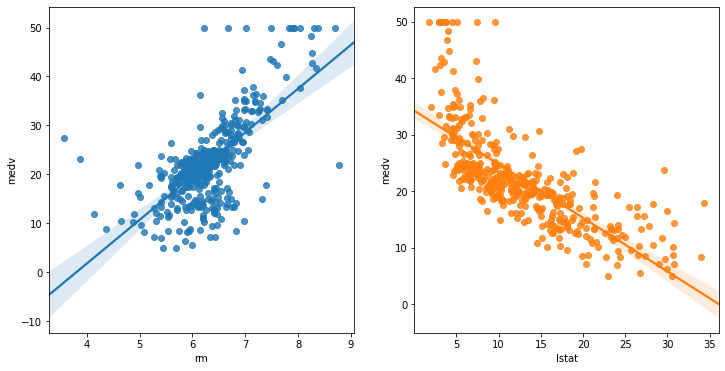

In [12]:
# the columns wit the strongest correlation with medv are rm and lstat

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.regplot(x="rm", y="medv", data=boston, ax=axs[0])
sns.regplot(x="lstat", y="medv", data=boston, ax=axs[1])

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [13]:
# Your response here
# I don't know what rm or lstat means so I wouldn't know what to expect but
# what the correlation values are saying is that as rm rises, so does the house price and
# as lstat decreases, the house price tends to rise

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

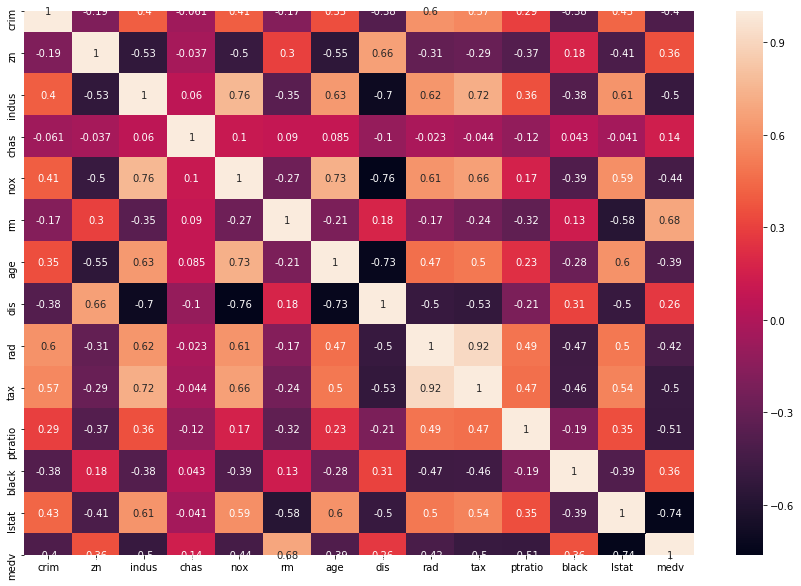

In [14]:
# Your response here
fig = plt.subplots(figsize=(15,10))
sns.heatmap(boston.corr(), annot=True)

In [15]:
# ptratio, tax and indus also have significant correlation values

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [16]:
# Your code here
print("median", boston["medv"].median())
boston["medv"].describe()

median 21.4


count    404.000000
mean      22.312376
std        8.837019
min        5.000000
25%       17.100000
50%       21.400000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [27]:
from sklearn.metrics import r2_score, mean_squared_error

def performance_metric(y_true, y_predict):
    """ Calculates and returns a tuple with the performance scores between 
        true and predicted values based on the R2 and MSE metrics. """
    # Your code here:
    return r2_score(y_true, y_predict), mean_squared_error(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the training and test. 

In [35]:
# Your code here
x = boston.drop("medv", axis=1)
y = boston["medv"]
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, random_state=34)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [36]:
# Five separate RFR here with the given max depths
max_depths = list(range(2, 11, 2))
models = [RandomForestRegressor(max_depth=n, n_estimators=10, random_state=24).fit(x_train, y_train) for n in max_depths]

Now, plot the score for each tree on the training set and on the testing set.

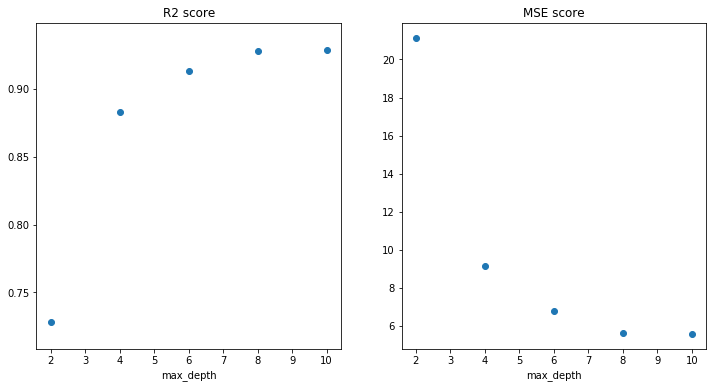

In [44]:
# Produce a plot with the score for the testing and training for the different max depths

y_pred = [m.predict(x) for m in models]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(max_depths, [performance_metric(y, pred)[0] for pred in y_pred])
axs[0].set_title("R2 score")
axs[0].set_xlabel("max_depth")

axs[1].scatter(max_depths, [performance_metric(y, pred)[1] for pred in y_pred])
axs[1].set_title("MSE score")
axs[1].set_xlabel("max_depth")

plt.show()

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [47]:
# Your response here
# Initially, the deeper the depth, the more accurate the results,
# but there is a point after which there is no improvement.

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10?

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

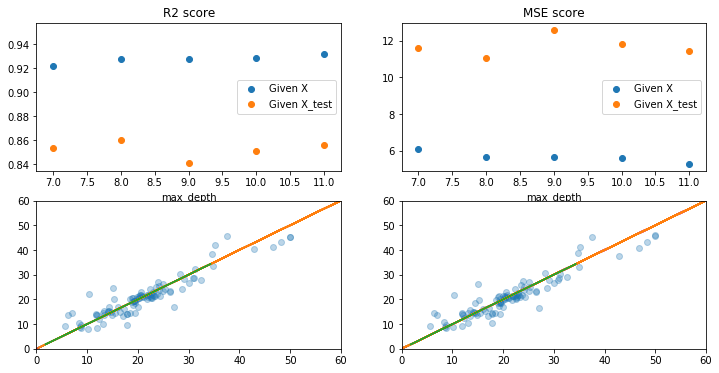

In [73]:
# Your response here
max_depths = [7,8,9,10,11]
models = [RandomForestRegressor(max_depth=n, n_estimators=10, random_state=24).fit(x_train, y_train) for n in max_depths]

y_pred = [m.predict(x) for m in models]
y_pred_test = [m.predict(x_test) for m in models]

fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0,0].scatter(max_depths, [performance_metric(y, pred)[0] for pred in y_pred], label="Given X")
axs[0,0].scatter(max_depths, [performance_metric(y_test, pred)[0] for pred in y_pred_test], label="Given X_test")
axs[0,0].set_title("R2 score")
axs[0,0].set_xlabel("max_depth")
axs[0,0].legend()

axs[0,1].scatter(max_depths, [performance_metric(y, pred)[1] for pred in y_pred], label="Given X")
axs[0,1].scatter(max_depths, [performance_metric(y_test, pred)[1] for pred in y_pred_test], label="Given X_test")
axs[0,1].set_title("MSE score")
axs[0,1].set_xlabel("max_depth")
axs[0,1].legend()

axs[1,0].plot(x, x)
axs[1,0].scatter(y_test, y_pred_test[1], alpha=0.3)
axs[1,0].set_xlim((0,60))
axs[1,0].set_ylim((0,60))

axs[1,1].plot(x, x)
axs[1,1].scatter(y_test, y_pred_test[4], alpha=0.3)
axs[1,1].set_xlim((0,60))
axs[1,1].set_ylim((0,60))

plt.show()

In [ ]:
# max_depth=8 appears to have the best accuracy score without overfitting the data

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answer:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [24]:
# Your response here